In [1]:
from db import PythonProblems
import io
import tokenize
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import random
import time
from itertools import product
from collections import Counter

In [2]:
from bokeh.models import ColumnDataSource, HoverTool, TapTool, PanTool, WheelZoomTool, Range1d, LinearAxis
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

### Connecting to database

In [3]:
db = PythonProblems('python.sqlite')

In [4]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', 'INDENT', 'DEDENT', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP']
cursor = db.conn.cursor()
docs = []
errors = []

# lendo os dados
cursor.execute("""
SELECT * FROM solution;
""")

for idx, linha in enumerate(cursor.fetchall()):
    file = io.StringIO(linha[1])
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (idx+1))
        
    docs.append(' '.join(doc))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Success in parsing all documents! You may go on!


In [5]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             #max_features = 26d,
                             binary=False,
                             min_df=2
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
train_data_features = train_data_features.toarray()

### NCut weights

In [7]:
doc_mat_norm = normalize(train_data_features)

In [8]:
S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001

In [9]:
S.shape

(499, 499)

In [10]:
D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])

In [11]:
D.shape

(499, 499)

In [12]:
Y = np.dot(D, train_data_features.T)

In [13]:
Y.shape

(499, 758)

# Cálculo da NMF

In [6]:
hover = HoverTool(tooltips=[
#    ("index", "$index"),
    ("(x,y)", "($x{0}, $y)"),
    ("reconst", "@recons"),
])
opts = dict(plot_width=250, plot_height=250, min_border=0)
models = {}

data = {'x_values': [],
        'y_values': [],
        'recons': []}

source = ColumnDataSource(data=data)

opts = dict(plot_width=900, plot_height=500, min_border=0, title="Ncut")
plot = figure(**opts)
plot.add_tools(hover)
l = plot.line(x='x_values', y='y_values', color="#2222aa", line_width=2, source=source)
c = plot.circle(x='x_values', y='y_values', color="#2222aa", fill_color="white", size=8, source=source)
h = show(plot, notebook_handle=True)

In [15]:
def edges_sum(cond_1, cond_2, S):
    nodes_1 = np.where(cond_1)[0]
    nodes_2 = np.where(cond_2)[0]
    
    # Every (x, y) index that I should get cooccurence value from S matrix
    indices = product(nodes_1, nodes_2)
    return np.sum(S[idx] for idx in indices)


def n_cut(mat_U, mat_S):
    
    # Each term belongs to which topic?
    # I can't make this assumption!!! 
    term_clusters = mat_U.argmax(axis=1)
    
    # Number of clusters
    n_k = mat_U.shape[1]
    
    result = 0.0
    for idx_k in range(n_k):
        
        # Check in which cluster the terms come from
        cond_g_k = term_clusters == idx_k
        
        # Sum edges between terms inside cluster and terms outside
        num = edges_sum(cond_g_k, ~cond_g_k, mat_S)
        
        # Sum all edges
        den = edges_sum(cond_g_k,  cond_g_k, mat_S) + num
        
        try:
            result += num/den
        except ZeroDivisionError:
            return 0
        
    return 0.5 * result

In [8]:
num_topics = list(range(2, 100))


In [7]:
#nt = sorted(num_topics[:50])

for k in num_topics:
    start_time = time.time()
    model = NMF(n_components=k, init="nndsvda", max_iter=1000, l1_ratio=0, alpha=1)
    V_T = model.fit_transform(Y.T)
    U_T = model.components_
    
    models[k] = {
            "model": model,
            "V_T": V_T,
#             "n_cut": n_cut_val,
            "recons": [model.reconstruction_err_]
        }

#     n_cut_val = n_cut(U_T.T, S)

#     if n_cut_val:

#         end_time = time.time()

#         x_values = [k]
#         y_values = [models[k]["n_cut"]/k]
#         #print("%d: %f" %(k, end_time - start_time))

#         new_data = {'x_values': x_values,
#                     'y_values': y_values,
#                     'recons': models[k]['recons']}
#         source.stream(new_data)
#         push_notebook(h)

NameError: name 'num_topics' is not defined

In [10]:
model = NMF(n_components=12, init="nndsvda", max_iter=1000, l1_ratio=0, alpha=1)
V_T = model.fit_transform(train_data_features)
U_T = model.components_

In [18]:
def coherence_norm(data, tf_idf_norm):
    clusters = np.argmax(data['V_T'], axis=1)
    n_clusters = data['V_T'].shape[1]
    
    clusters_norm = []
    clusters_size = []
    coherence_cluster = []
    
    for idx_cluster in range(n_clusters):
        
        cluster_data = tf_idf_norm[clusters == idx_cluster]
        avg_vector = np.average(cluster_data, axis=0)
        cluster_norm = np.sqrt(np.power(avg_vector, 2).sum())
        clusters_norm.append(cluster_norm)
        clusters_size.append(cluster_data.shape[0])
        
        if cluster_data.shape[0] > 3:
            coherence_cluster.append(cluster_norm)
    
    
    data['avg_clusters_norm'] = clusters_norm
    data['clusters_size'] = clusters_size
    data['coherence_norm'] = np.average(clusters_norm)
    return np.average(coherence_cluster), np.std(clusters_norm)

In [19]:
for key in sorted(models.keys()):
    coherence_norm(models[key], doc_mat_norm)

In [23]:
data_x = sorted(models.keys())
data_ncut = [models[x]["n_cut"]/x for x in data_x]
data_coh = [models[x]["coherence_norm"] for x in data_x]

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x, y)", "($x{0}, $y)"),        ]
    )


plot = figure(title="Ncut vs Coherence", plot_height=500, plot_width=900,
    tools=[hover, PanTool(), WheelZoomTool()])

plot.line(data_x, data_ncut, color="#2222aa", line_width=2)
#plot.circle(data_x, data_ncut, color="#2222aa", fill_color="white", size=8)

plot.extra_y_ranges = {"coherence": Range1d(start=0.0, end=1.0)}
plot.line(data_x, data_coh, line_width=2, color="red", y_range_name="coherence")
plot.add_layout(LinearAxis(y_range_name="coherence"), 'right')

show(plot)

In [25]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
vocab_cell = np.asarray(vocab).astype(object)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [38]:
V_T = models[10]['V_T']
V_T.shape

(758, 10)

In [12]:
row_sums = V_T.sum(axis=1)
new_matrix = V_T / row_sums[:, np.newaxis]
new_matrix.shape

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(758, 12)

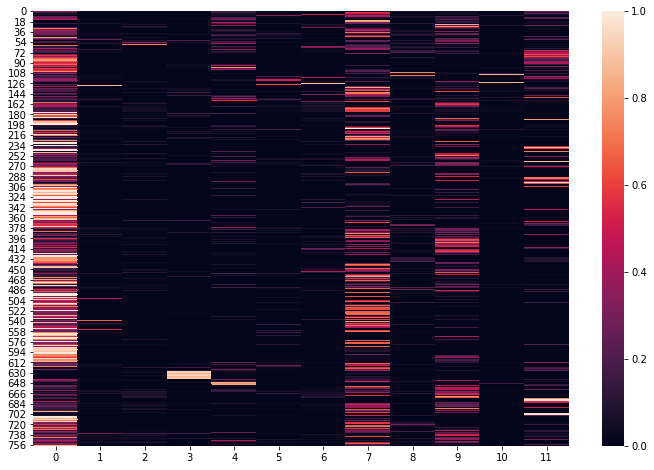

In [15]:
fig = plt.figure(figsize=(12,8))
ax = sns.heatmap(new_matrix)
plt.show()

In [18]:
Counter(np.argmax(V_T, axis=1))

Counter({0: 337,
         1: 4,
         2: 4,
         3: 14,
         4: 20,
         5: 7,
         6: 9,
         7: 202,
         8: 6,
         9: 93,
         10: 3,
         11: 59})

In [19]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [21]:
print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = vectorizer.get_feature_names()
print_top_words(model, tfidf_feature_names, 26)


Topics in NMF model (Frobenius norm):
Topic #0: print format elif import tuplex os if time random math decimal quote setupvalues in array_num randint sys binarystring and menuchoice context str1 path from or try
Topic #1: startplayer counter board if def else return false print and connect true not while for column elif in format range row win input append item setupgame
Topic #2: game return def row player if winner for in game_slices range column print append and true width row_num col_num new_row convert_input_to_coordinate display_game index draw_line display_winner str
Topic #3: result_str row column and or range for in else if print col elif win true step square start sys int main nums timer try lower find
Topic #4: elif month if else day input year int in and true or false number ast try print isinstance guess break re answer not win lower continue
Topic #5: shoppinglist print element menuchoice false nomoreswaps finished item tempitem true def not while temp len if else input 